### LOGISTIC REGRESSION RE-IMPLEMENTATION

In [171]:
import numpy as np
from enum import Enum
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


class LogisticRegression:
    class Method(Enum):
        GRADIENT_DESCENT = 1

    def __init__(
        self,
        learning_rate=1e-5,
        epochs=2000,
        method=Method.GRADIENT_DESCENT,
        tol=1e-7,
    ):
        self.learning_rate = learning_rate
        self.N = None
        self.d = None
        self.epochs = epochs
        self.method = method
        self.tol = tol
        self.loss_history = []

    def fit(self, X, y):
        # m training samples, n features
        # convert the raw array into NDArray
        X = np.asarray(X)
        if X.ndim == 1:
            X = X.reshape(-1, 1)
        # (m, 1)
        y = np.asarray(y).reshape(-1, 1)

        self.N, self.d = X.shape
        # initial sampling
        # the weights of the model
        self.w = np.zeros((self.d, 1))
        # the bias of the model
        self.b = 0.0

        previous_loss = float("inf")

        def p_hat(X, w, b):
            z = X @ w + b
            z = np.clip(z, -500, 500)
            return 1 / (1 + np.exp(-z))

        def L(y, p_hat):
            return -np.mean(
                y * np.log(p_hat + 1e-15) + (1 - y) * np.log(1 - p_hat + 1e-15)
            )

        # parameters as w, b
        # the loss depends on w and b
        def dL_over_dw(p_hat):
            return (1 / self.N) * (X.T @ (p_hat - y))

        def dL_over_db(p_hat):
            r = p_hat - y
            return np.mean(r)

        # the traning process using gradient descent
        # to find the parameters that make the J min
        for i in range(self.epochs):
            # forward pass
            current_predit = p_hat(X, self.w, self.b)
            Loss = L(y, current_predit)
            # print("-Loss function: ", Loss)
            self.loss_history.append(Loss)

            # backward pass
            rate_of_change_J_w = dL_over_dw(current_predit)
            rate_of_change_J_b = dL_over_db(current_predit)

            # update parameters
            self.w = self.w - self.learning_rate * rate_of_change_J_w
            self.b = self.b - self.learning_rate * rate_of_change_J_b

            # convergence method
            if abs(Loss - previous_loss) < self.tol:
                # print(f"Convergence after {i} epochs")
                break

            previous_loss = Loss

    def predict(self, X):
        # (a, n) a new samples
        # (n, 1)
        # (a, 1)
        if X.ndim == 1:
            X = X.reshape(-1, 1)
        # a samples
        a, _ = X.shape
        prob = 1 / (1 + np.exp(-(X @ self.w + self.b * np.ones((a, 1)))))
        return (prob >= 0.5).astype(int)

    def parameters(self):
        print("W: ", self.w)
        print("b: ", self.b)

    @staticmethod
    def sigmoid(x):
        return 1 / (1 + np.exp(-x))

    def view_loss(self):
        train = pd.DataFrame(
            data={"Epoch": range(len(self.loss_history)), "Loss": self.loss_history}
        )

        plt.figure(figsize=(7, 5))
        sns.lineplot(data=train, x="Epoch", y="Loss")

        plt.xlabel("Epoch")
        plt.ylabel("Loss (Cross-entropy)")
        plt.title("Loss vs Epoch")
        plt.grid(True)

        plt.show()

    def info(self):
        print("- Training samples: ", self.m)
        print("- Number of features: ", self.n)

    def get_params(self, deep=True):
        return {
            "learning_rate": self.learning_rate,
            "epochs": self.epochs,
            "method": self.method,
            "tol": self.tol,
        }

    def set_params(self, **params):
        for key, value in params.items():
            if hasattr(self, key):
                setattr(self, key, value)
        return self


### TEST THE MODEL WITH A DATASET

In [5]:
! pip install kaggle
! kaggle competitions download -c titanic
! unzip ./titanic.zip -d ./data/titanic
! rm ./titanic.zip

titanic.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  ./titanic.zip
  inflating: ./data/titanic/gender_submission.csv  
  inflating: ./data/titanic/test.csv  
  inflating: ./data/titanic/train.csv  


### EXPLORE THE DATASET

### CLEANING

- Remove irrelent columns
- filling age

In [226]:
from sklearn.preprocessing import StandardScaler

train = pd.read_csv("./data/titanic/train.csv")

train = train.drop(columns=["Cabin", "Name", "Ticket"])

age_median = train["Age"].median()
fare_median = train["Fare"].median()
embarked_mode = train["Embarked"].mode()[0]

train["Age"] = train["Age"].fillna(age_median)
train["Embarked"] = train["Embarked"].fillna(embarked_mode)
train["Sex"] = train['Sex'].map({'male':0, 'female':1})
train = pd.get_dummies(train, columns=['Embarked'], drop_first=True)
train["FamilySize"] = train["SibSp"] + train["Parch"] + 1
train["IsAlone"] = (train["FamilySize"] == 1).astype(int)

y_train = train['Survived']
X_train = train.drop(columns=["Survived", "PassengerId"])

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train) 

In [205]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Sex          891 non-null    int64  
 4   Age          891 non-null    float64
 5   SibSp        891 non-null    int64  
 6   Parch        891 non-null    int64  
 7   Fare         891 non-null    float64
 8   Embarked_Q   891 non-null    bool   
 9   Embarked_S   891 non-null    bool   
 10  FamilySize   891 non-null    int64  
 11  IsAlone      891 non-null    int64  
dtypes: bool(2), float64(2), int64(8)
memory usage: 71.5 KB


- Tune the model for check for hyperparameters

In [223]:
from sklearn.model_selection import GridSearchCV

X_train = X_train.to_numpy(dtype=float)
my_logistic_regression = LogisticRegression()

param_grid = {
    "learning_rate": [0.2, 0.1, 0.01, 0.001, 0.0001],
    "epochs": [100, 500, 1000, 2000, 6000],
    "tol": [1e-6, 1e-7, 1e-8]
}

grid = GridSearchCV(
    estimator=my_logistic_regression,
    param_grid=param_grid,
    scoring='accuracy',
    cv=5
)

grid.fit(X_train, y_train)
print(grid.best_params_)
print(grid.best_score_)

{'epochs': 6000, 'learning_rate': 0.01, 'tol': 1e-06}
0.7452200112987258


- Train the model using the training data

In [224]:
best_model = LogisticRegression(
    learning_rate=grid.best_params_["learning_rate"],
    epochs=grid.best_params_["epochs"],
    tol=grid.best_params_["tol"]
)

best_model.fit(X_train_scaled, y_train)

- Predict on the test data

In [225]:
test = pd.read_csv("./data/titanic/test.csv")

train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_Q,Embarked_S,FamilySize,IsAlone
0,1,0,3,0,22.0,1,0,7.2500,False,True,2,0
1,2,1,1,1,38.0,1,0,71.2833,False,False,2,0
2,3,1,3,1,26.0,0,0,7.9250,False,True,1,1
3,4,1,1,1,35.0,1,0,53.1000,False,True,2,0
4,5,0,3,0,35.0,0,0,8.0500,False,True,1,1


- Apply the same preprocessing for the test file

In [227]:
test = pd.read_csv("./data/titanic/test.csv")
test = test.drop(columns=["Cabin", "Name", "Ticket"])

test["Age"] = test["Age"].fillna(age_median)
test["Fare"] = test["Fare"].fillna(fare_median)
test["Embarked"] = test["Embarked"].fillna(embarked_mode)

test["Sex"] = test["Sex"].map({'male':0, 'female':1})
test = pd.get_dummies(test, columns=['Embarked'], drop_first=True)

for col in ["Embarked_Q", "Embarked_S"]:
    if col not in test.columns:
        test[col] = 0

test["FamilySize"] = test["SibSp"] + test["Parch"] + 1
test["IsAlone"] = (test["FamilySize"] == 1).astype(int)

X_test = test[X_train.columns]
X_test = X_test.to_numpy(dtype=float)
X_test_scaled = scaler.transform(X_test)

/home/zun/.cache/pypoetry/virtualenvs/linear-regression-model-b3Q1w9Tj-py3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


- predict the value on the test set

In [230]:
y_pred = best_model.predict(X_test_scaled)

submission = pd.DataFrame({
    "PassengerId": pd.read_csv("./data/titanic/test.csv")["PassengerId"],
    "Survived": y_pred.ravel()
})
submission.to_csv("./submissions/titanic.csv", index=False)

- IMAGE

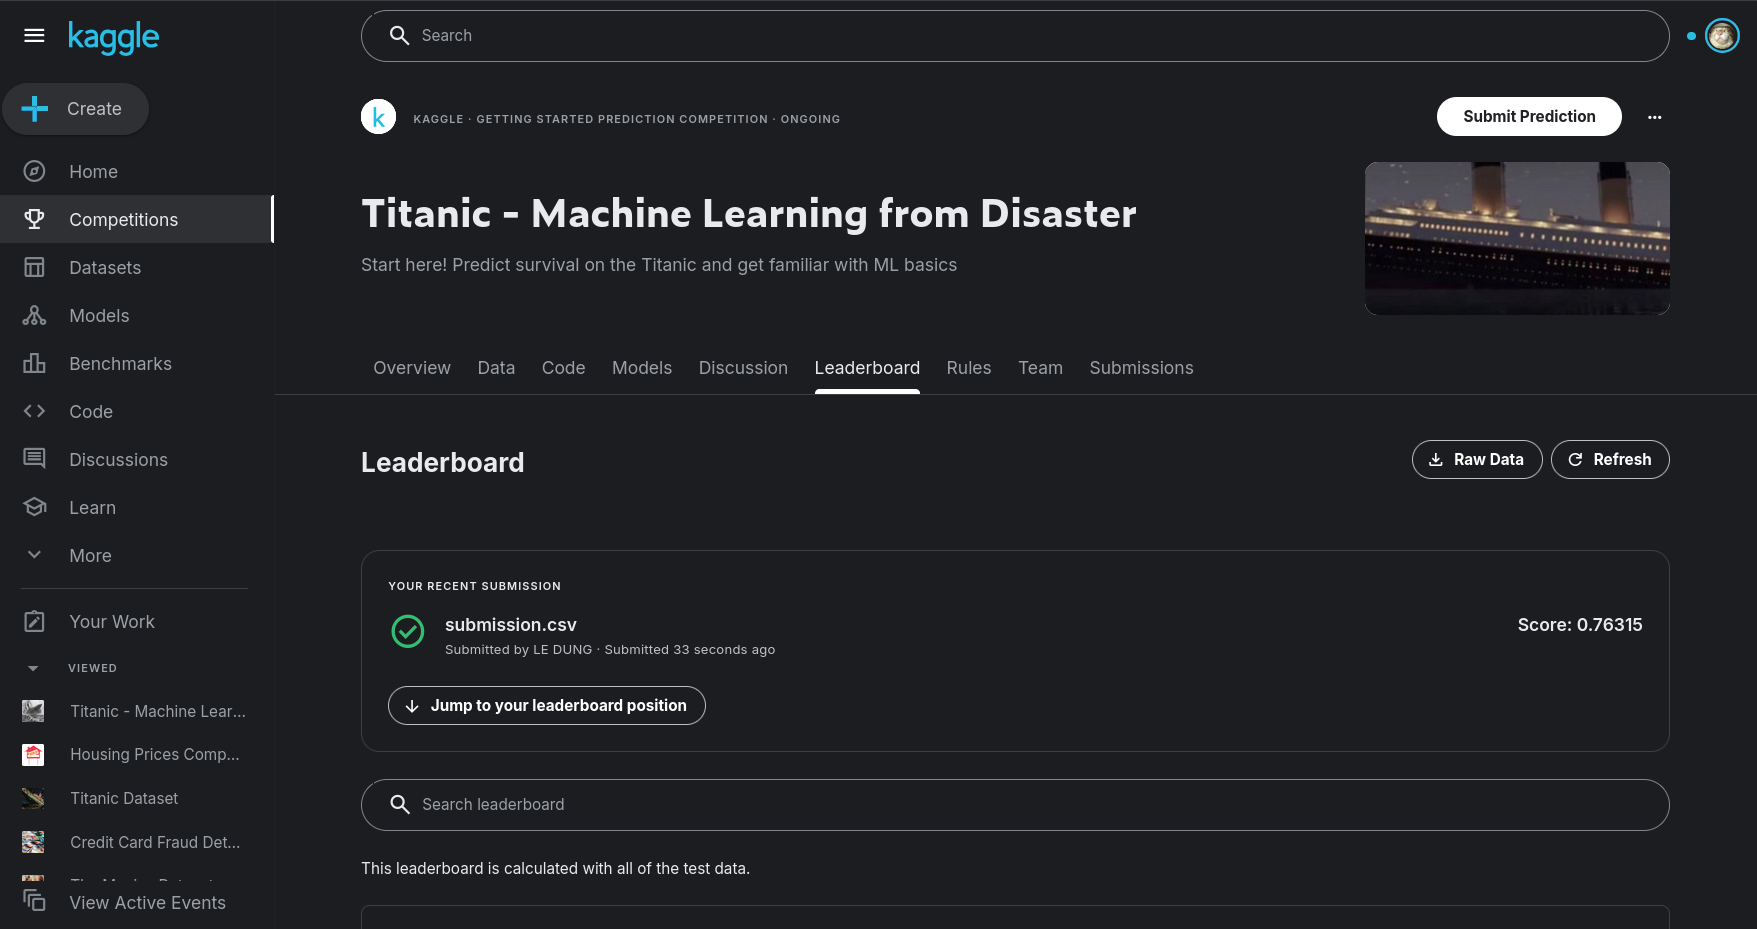

In [229]:
from IPython.display import Image, display

display(Image(filename='./submissions/titanic.png'))